## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


##  First，import some package

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


## Second,I'll creat some tools

### general functions

In [2]:

def read_image(filepath,plat = "cv"):
    if plat == "cv":
        return cv2.imread(filepath)
    else:
        return plt.imread(filepath)

def grayscale(img,plat = 'cv'):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    if plat == "cv":
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    

def gaussian_smoothing(gray_img,kernel_size = 5):

    return cv2.GaussianBlur(gray_img,(kernel_size, kernel_size),0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_outside_line(img,vertices,color=[0, 0, 255], thickness=3):
    cv2.line(img,tuple(vertices[0][0]),tuple(vertices[0][1]),[0,255,0],thickness)
    cv2.line(img,tuple(vertices[0][2]),tuple(vertices[0][3]),[0,255,0],thickness)
    cv2.line(img,tuple(vertices[0][1]),tuple(vertices[0][2]),[0,255,0],thickness)
    cv2.line(img,tuple(vertices[0][4]),tuple(vertices[0][5]),[0,255,0],thickness)
    cv2.line(img,tuple(vertices[0][5]),tuple(vertices[0][6]),[0,255,0],thickness)
    
    



    

        


    
    
    
    
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### camera calibration

In [3]:
def get_images(files = '../camera_cal/calibration*.jpg'):
    '''
    获取校准文件数组
    '''
    return glob.glob(files)



def get_points(images,point_size = (9,6)):
    '''
    获取校准点的数组
    '''

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = read_image(fname)
        gray = grayscale(img)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, point_size,None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints,imgpoints

def cal_undistort(img, mtx, dist):
    '''
    获取校准后的图像
    '''

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def get_cal_matrices(img, objpoints, imgpoints):
    '''
    获取校准矩阵
    '''
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    
    return  ret, mtx, dist



###  create a thresholded binary image

#### Sobel

In [4]:
def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
    获取某个维度上经过索贝尔算子获得的边缘图
    '''

    
    if orient == "x":
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    elif orient == "y":
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mask = (scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])
    grad_binary = np.zeros_like(gray_img)
    grad_binary[mask] = 1
    
    return grad_binary

def mag_thresh(gray_img, sobel_kernel=3, thresh=(0, 255)):
    '''
    获取x轴和y轴合成的梯度大小在范围内的边缘图
    '''
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    sobel = np.sqrt(sobelx ** 2+ sobely ** 2)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    mask = (scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])
    mag_binary = np.zeros_like(gray_img)
    mag_binary[mask] = 1
    return mag_binary

def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    获取梯度角度在一定范围内的边缘图
    '''
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    # sobel = np.sqrt(sobelx ** 2+ sobely ** 2)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    mask = (arctan > thresh[0]) & (arctan < thresh[1])
    dir_binary = np.zeros_like(gray_img) # Remove this line
    dir_binary[mask] = 1
    return dir_binary

#### Color space

In [5]:
def hls_select(img,channel = "S", thresh=(0, 255)):
    '''
    获取hls空间某个维度的阈值
    '''

    hls_image = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    if channel ==  "S":
        mask = (hls_image[:,:,2] > thresh[0]) &  (hls_image[:,:,2] <= thresh[1])
    elif channel ==  "H":
        mask = (hls_image[:,:,0] > thresh[0]) &  (hls_image[:,:,0] <= thresh[1])
    elif channel == "L":
        mask = (hls_image[:,:,1] > thresh[0]) &  (hls_image[:,:,1] <= thresh[1])
    else:
        return None
    binary_output = np.zeros_like(hls_image[:,:,2]) # placeholder line
    binary_output[mask] = 1
    return binary_output


def bgr_select(image,channel = "R",thresh = (0,255)):
    '''
    获取BGR空间某个维度的阈值
    '''
    if channel ==  "R":
        mask = (image[:,:,2] > thresh[0]) &  (image[:,:,2] <= thresh[1])
    elif channel ==  "B":
        mask = (image[:,:,0] > thresh[0]) &  (image[:,:,0] <= thresh[1])
    elif channel == "G":
        mask = (image[:,:,1] > thresh[0]) &  (image[:,:,1] <= thresh[1])
    else:
        return None
    binary_output = np.zeros_like(image[:,:,2]) # placeholder line
    binary_output[mask] = 1
    return binary_output




###  Rectify binary image

In [6]:
def get_recitify_element(img,image, rho, theta, threshold, min_line_len, max_line_gap,vertices):
    """
    使用霍夫空间拟合直线，获取四个参考点，作为校正图像的src
    """
    
    
    def get_x(y,fit):
        return int((y - fit[1])/fit[0])
    
    def get_fit(fit_list,length_list):
        '''
        Calculate lane lines using weights
        '''
        fit = [0,0]
        for i in range(len(fit_list)):
            fit[0] += fit_list[i][0] * (length_list[i]/sum(length_list))
            fit[1] += fit_list[i][1] * (length_list[i]/sum(length_list))
        return fit
            
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,maxLineGap=max_line_gap)
    
    lfit_list = []
    llength_list = []
    rlength_list = []
    rfit_list = []
    lx1,lx2,ly1,ly2 = 0,0,0,0
    rx1,rx2,ry1,ry2 = 0,0,0,0
    # get fit list
    for line in lines:
        if line.any():
            for x1, y1, x2, y2 in line:
                length = (((y1-y2) ** 2) + ((x1 -x2) ** 2)) ** 0.5
                if x1 == x2 or y1 == y2:
                    continue
                fit = np.polyfit((x1,x2),(y1,y2),1)
                if (fit[0] >0.25):
                    rfit_list.append(fit)
                    rlength_list.append(length)

                elif (fit[0] < -0.25) :
                    lfit_list.append(fit)
                    llength_list.append(length)


    # get fit
    lfit = get_fit(lfit_list,llength_list)
    rfit = get_fit(rfit_list,rlength_list)
    
    
    
    # get left line
    if len(lfit) > 0 and lfit != [0,0]:
        ly1 = vertices[0][0][1]
        ly2 = vertices[0][1][1]+50
        lx1 = get_x(ly1,lfit)
        lx2 = get_x(ly2,lfit)

    #get right line
    if len(rfit) > 0 and rfit != [0,0]:
        ry1 = vertices[0][2][1] +50
        ry2 = vertices[0][3][1]
        rx1 = get_x(ry1,rfit)
        rx2 = get_x(ry2,rfit)    
    
    p1 = (lx1,ly1)
    p2 = (lx2,ly2)
    p3 = (rx1,ry1)
    p4 = (rx2,ry2)
    
    # 画出左右车道线的线框
#     cv2.line(image,p1,p2,[0,255,0],3)
#     cv2.line(image,p2,p3,[0,255,0],3)
#     cv2.line(image,p3,p4,[0,255,0],3)
    
    src = np.float32([p1,p2,p3,p4])
    dst = np.float32([p1,(p1[0],p2[1]/2),(p4[0],p3[1]/2),p4])
#     dst = np.float32([p1,(p1[0],0),(p4[0],0),p4])

    
    return image,src,dst




def get_M(undist_img, src, dst):
    '''
    获取投影矩阵
    '''
#         src = np.float32([p1,p2,p3,p4])
#         dst = np.float32([[100,100],[250,100],[250,250],[100,250]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_R = cv2.getPerspectiveTransform(dst,src)
    return M,M_R


def recity_unwarp(undist_img, M):
    '''
    将校正后的图像根据M转化为鸟瞰图
    '''
    warped = cv2.warpPerspective(undist_img, M, undist_img.shape[::-1], flags=cv2.INTER_LINEAR)
    return warped

def recity_unwarp_full(image,M):

    '''
    将校正后的图像根据M转化为鸟瞰图,三通道
    '''
    warped = cv2.warpPerspective(image, M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped



### Detect lane pixels and fit to find the lane boundary.

In [53]:
def find_lane_pixels(binary_warped,nwindows = 9,margin = 100,minpix = 50):
    '''
    找到所有的有效的左右车道线坐标值
    '''
    # 获取图像下半部分像素值y轴上相加的直方图
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # 找到图像中点，将其分为左右两部分
    midpoint = np.int(histogram.shape[0]//2)
    
    # 返回每一边最大直方图顶点对应的索引，
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # 超参数
    # 分成几个窗口
    # nwindows = 9
    # 窗口的宽度+/- margin
    # margin = 100
    #寻找中心线的最小像素数
    # minpix = 50

    # 求出窗口的高度
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # 返回二值图非0元素的X坐标元组，y坐标元组
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # 当前窗口中心线的位置，在每个窗口中更新
    leftx_current = leftx_base
    rightx_current = rightx_base

    # 用来储存每个窗口的左右车道的非零像素的索引
    left_lane_inds = []
    right_lane_inds = []

    # 对于每个窗口
    for window in range(nwindows):
        #找到y边界
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        #找到x边界
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        

        # 画出窗口的边界线
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # 获取窗口区域的值，分别是从y轴和x轴限制
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        # 将获取到的不为0的x的坐标索引储存
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        

        # 如果获取到的像素点数目大于阈值，则设置下个窗口的中点值，中点值为有效坐标的平均值
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # 有效像素列表进行拼接，拼接为np数组，列表为x和y的坐标数组中的索引
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # 从坐标数组中中获取对应的像素索引的x和y的坐标
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    '''
    拟合左右曲线，以Y轴为自变量，X轴为因变量，
    因为车道线相对来说是比较垂直，以X轴为自变量可能不太好拟合，会存在一个x对应几个y，所有以y为自变量
    '''
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    # 获取x轴
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # 获取左右的多项式，fit为系数，ploty为y值,是y为自变量
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit,right_fit,left_fitx, right_fitx, ploty


def search_around_poly(binary_warped,left_fit,right_fit,margin = 100):
    '''
    通过将拟合的曲线左右延伸来获取下一帧图像的优先检测区域，若检测不到，可以再次从传统窗口检测
    
    '''
    # 超参数，设置拟合线左右的边距 margin = 100
    

    # 获取有效像素
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    

    # Fit new polynomials
    left_fit,right_fit,left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    
    
    return left_fit,right_fit,left_fitx, right_fitx, ploty


### Determine the curvature of the lane and vehicle position with respect to center.

In [8]:
def measure_curvature_pixels(binary_warped,ploty, left_fit, right_fit):
    '''
    y以像素为单位计算曲率
    '''

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # 通过公式计算曲率
    left_curverad =((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2) ** 1.5) / np.absolute(2*left_fit[0])
    
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1] ) ** 2)**1.5)/np.absolute(2*right_fit[0])
    
    cam_middle = binary_warped.shape[1]/2 
#     print('cam_middle',cam_middle)
    
    road_left = (left_fit[0] * (y_eval ** 2)) + (left_fit[1] * y_eval) + left_fit[2]
    road_right = (right_fit[0] * (y_eval ** 2)) + (right_fit[1] * y_eval) + right_fit[2]
    road_middle = (road_right+road_left)/2 
#     print('road_middle',road_middle)
    distance = cam_middle - road_middle
    
    
    
    
    return left_curverad, right_curverad,distance 


def measure_curvature_real(binary_warped,ploty, left_fit_cr, right_fit_cr,ym_per_pix = 30/720,xm_per_pix = 3.7/700):
    '''
    y以现实距离计算曲率
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # 利用公式计算曲率
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #计算摄像头中心线和车道中心线的距离
    
    cam_middle = binary_warped.shape[1]/2 
#     print('cam_middle',cam_middle)
    
    road_left = (left_fit_cr[0] * (y_eval ** 2)) + (left_fit_cr[1] * y_eval) + left_fit_cr[2]
    road_right = (right_fit_cr[0] * (y_eval ** 2)) + (right_fit_cr[1] * y_eval) + right_fit_cr[2]
    road_middle = (road_right+road_left)/2 
#     print('road_middle',road_middle)
    distance = (cam_middle - road_middle) * xm_per_pix
    
    
    return left_curverad, right_curverad,distance

### show

In [60]:
def get_draw(binary_warped,left_fitx,right_fitx, ploty):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # 获取窗口左右的边界

    windows_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])  #将x和y组合成2维的数组，转置为（x，y）
    windows_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])  #转置后再反转
    windows = np.hstack((windows_left, windows_right)) #将点数组合并
    
    

    # 画出车道区域

    cv2.fillPoly(window_img, np.int_([windows]), (0,255, 0),cv2.LINE_8)
    
    #画出边框
    cv2.polylines(window_img, np.int_([windows]),False,(255,0,0),12,cv2.LINE_8)

    
    return window_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output after processing
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


### put text to the image

In [10]:
def get_info_text(left_curverad, right_curverad,distance):

    if distance > 0 :
        msg1 = 'curverad:%sm'%((left_curverad + right_curverad)/2)
        msg2 = 'distance-right:%sm'%abs(distance)
    else:
        msg1 = 'curverad:%sm'%((left_curverad + right_curverad)/2)
        msg2 = 'distance-left:%sm'%abs(distance)
    
    return [msg1,msg2]



def put_text2img(img,msg_list):
    '''
    将字符串写到图片上
    '''
    i = 0
    for msg in msg_list:
        cv2.putText(img, msg, (40, 50+50*i), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
        i+=1

## Process image

### cal camera

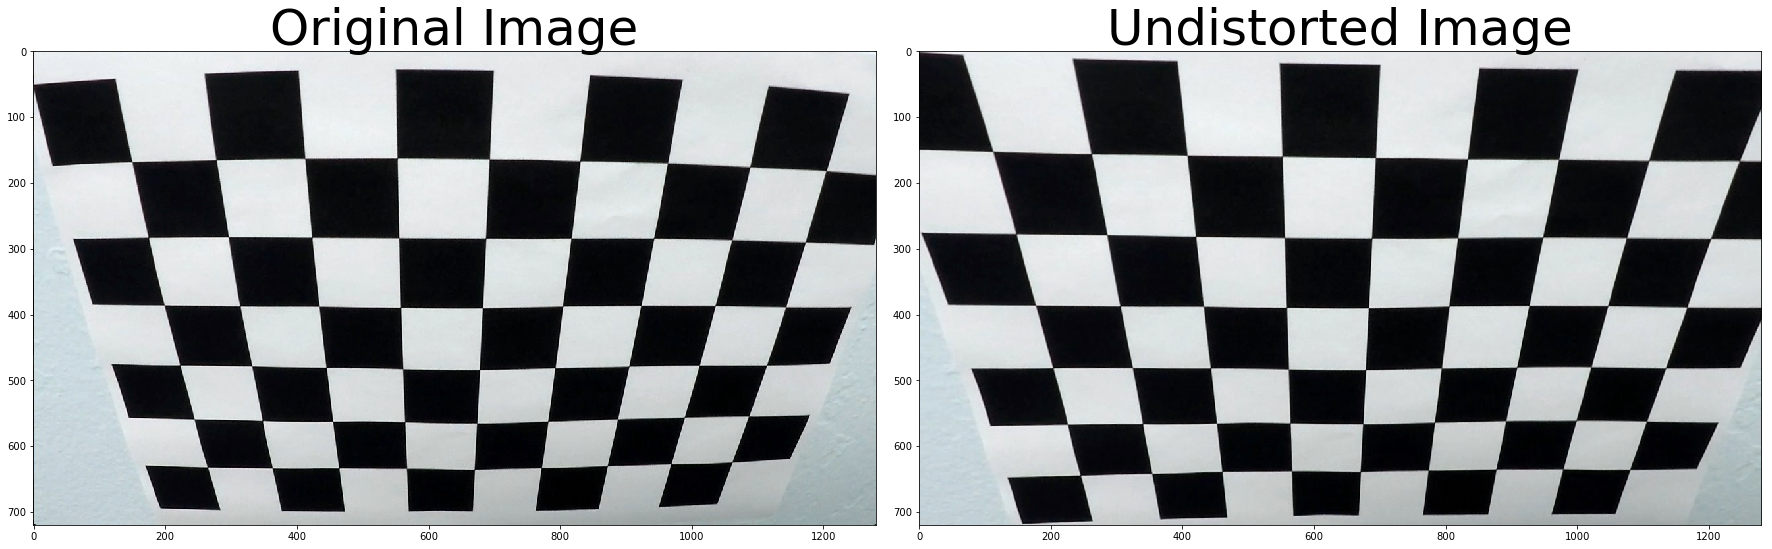

In [113]:
images = get_images('./camera_cal/calibration*.jpg')
objpoints,imgpoints = get_points(images)
img = read_image(images[4])
ret,mtx,dist = get_cal_matrices(img,objpoints,imgpoints)
image = cal_undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

[[1.15778044e+03 0.00000000e+00 6.67107095e+02]
 [0.00000000e+00 1.15282396e+03 3.86131918e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


True

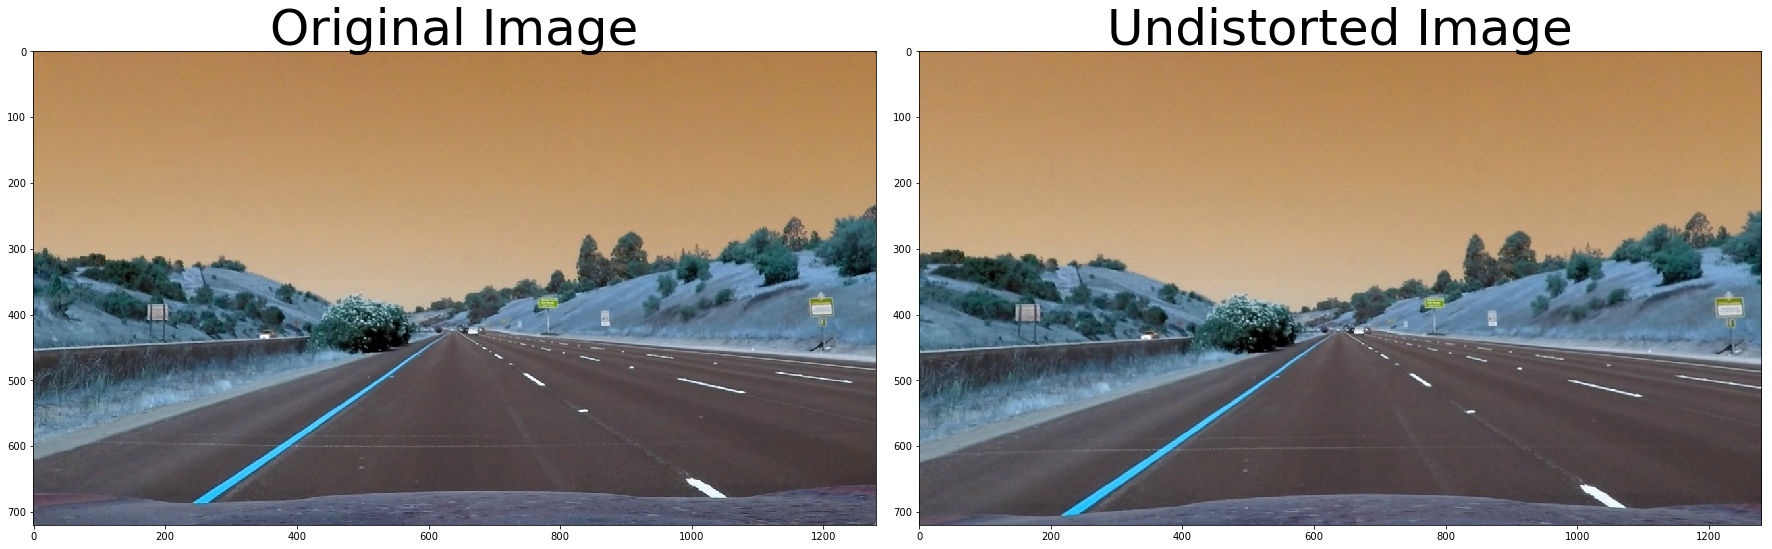

In [110]:
images = get_images('./camera_cal/calibration*.jpg')
objpoints,imgpoints = get_points(images)
img = read_image("./test_images/straight_lines1.jpg")
ret,mtx,dist = get_cal_matrices(img,objpoints,imgpoints)
print(mtx)
image = cal_undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/Undistorted_Image.jpg",image)

### create a thresholded binary image

In [13]:
# image = read_image("./test_images/straight_lines1.jpg")
# inds_image = cal_undistort(image, mtx, dist)
# gray_img = grayscale(inds_image)
# gray_img = gaussian_smoothing(gray_img,kernel_size = 5)

In [14]:
image = read_image("./test_images/straight_lines1.jpg","plt")
inds_image = cal_undistort(image, mtx, dist)
gray_img = grayscale(inds_image,"plt")
gray_img = gaussian_smoothing(gray_img,kernel_size = 5)

True

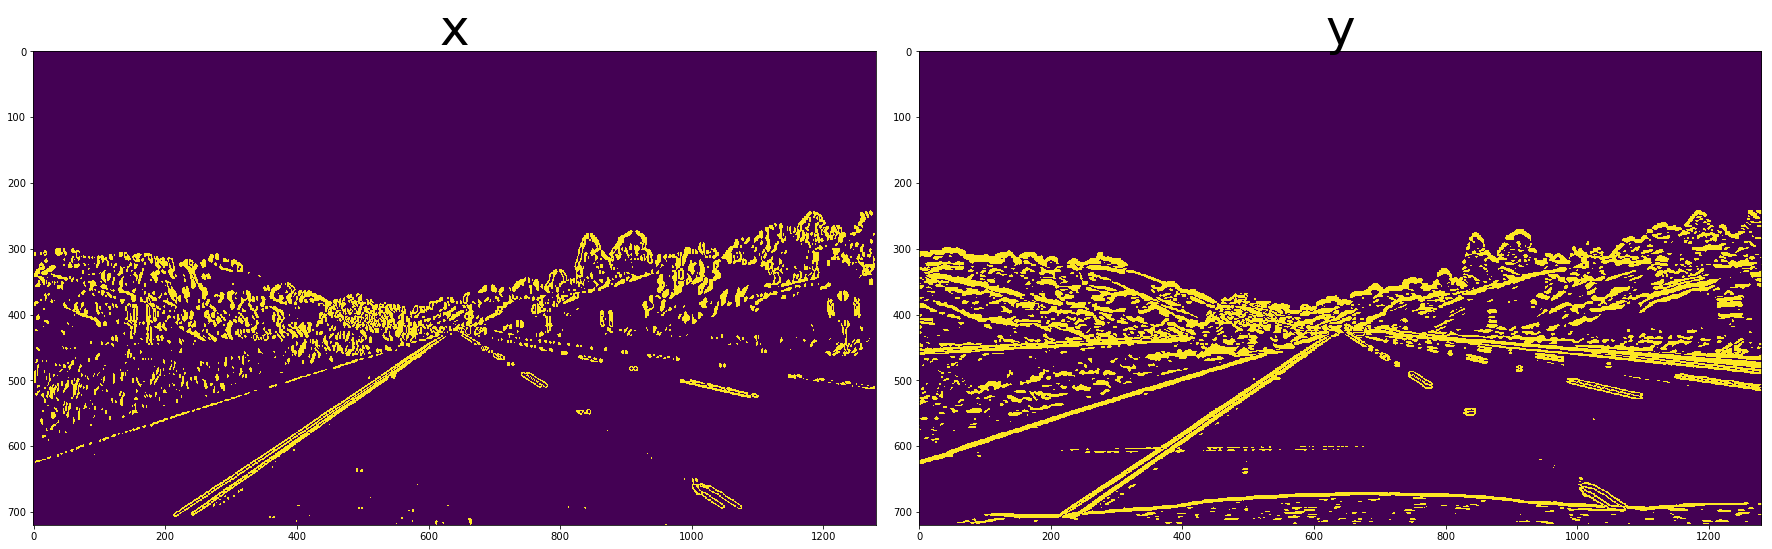

In [111]:

abs_sobel_x = abs_sobel_thresh(gray_img,orient="x",sobel_kernel=9,thresh=(20,100))
abs_sobel_y = abs_sobel_thresh(gray_img,orient="y",sobel_kernel=9,thresh=(20,150))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(abs_sobel_x)
ax1.set_title('x', fontsize=50)
ax2.imshow(abs_sobel_y)
ax2.set_title('y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




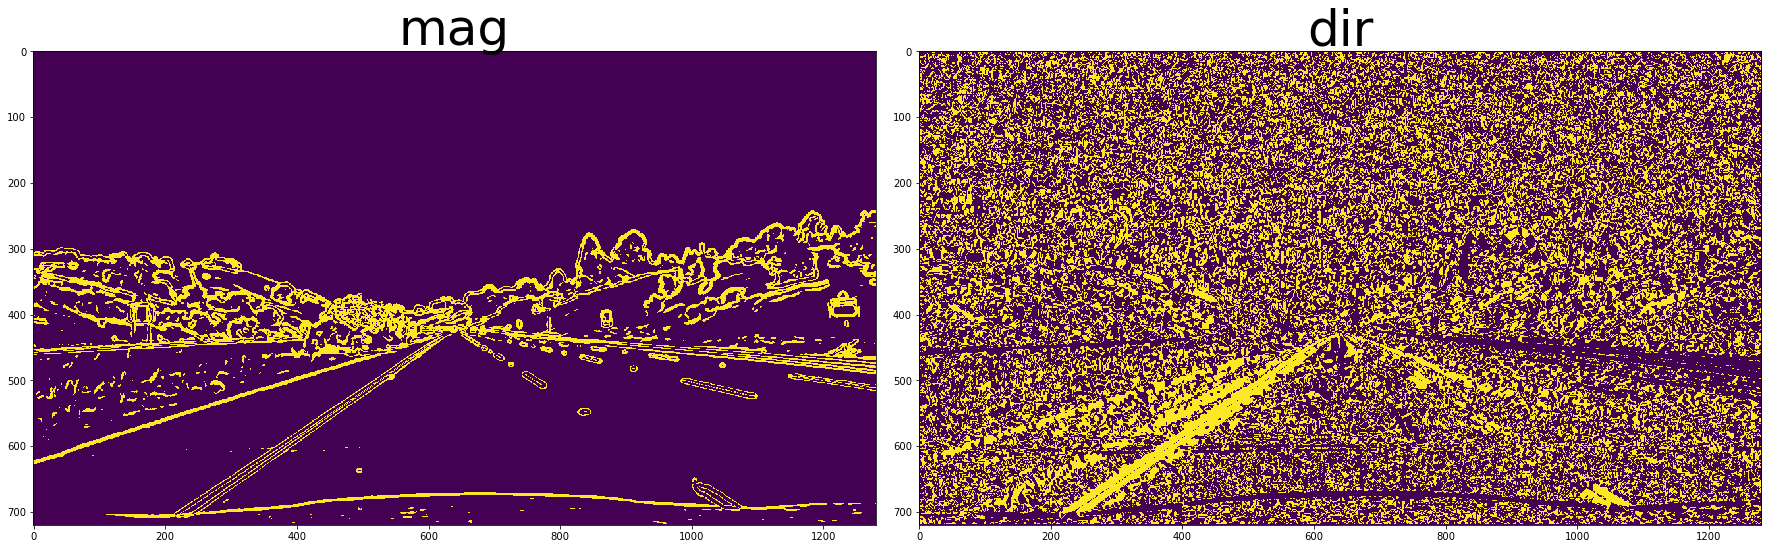

In [16]:
mag_binary = mag_thresh(gray_img,sobel_kernel=9,thresh=(30,100))
dir_binary = dir_threshold(gray_img,sobel_kernel=15,thresh=(0.8, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mag_binary)
ax1.set_title('mag', fontsize=50)
ax2.imshow(dir_binary)
ax2.set_title('dir', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




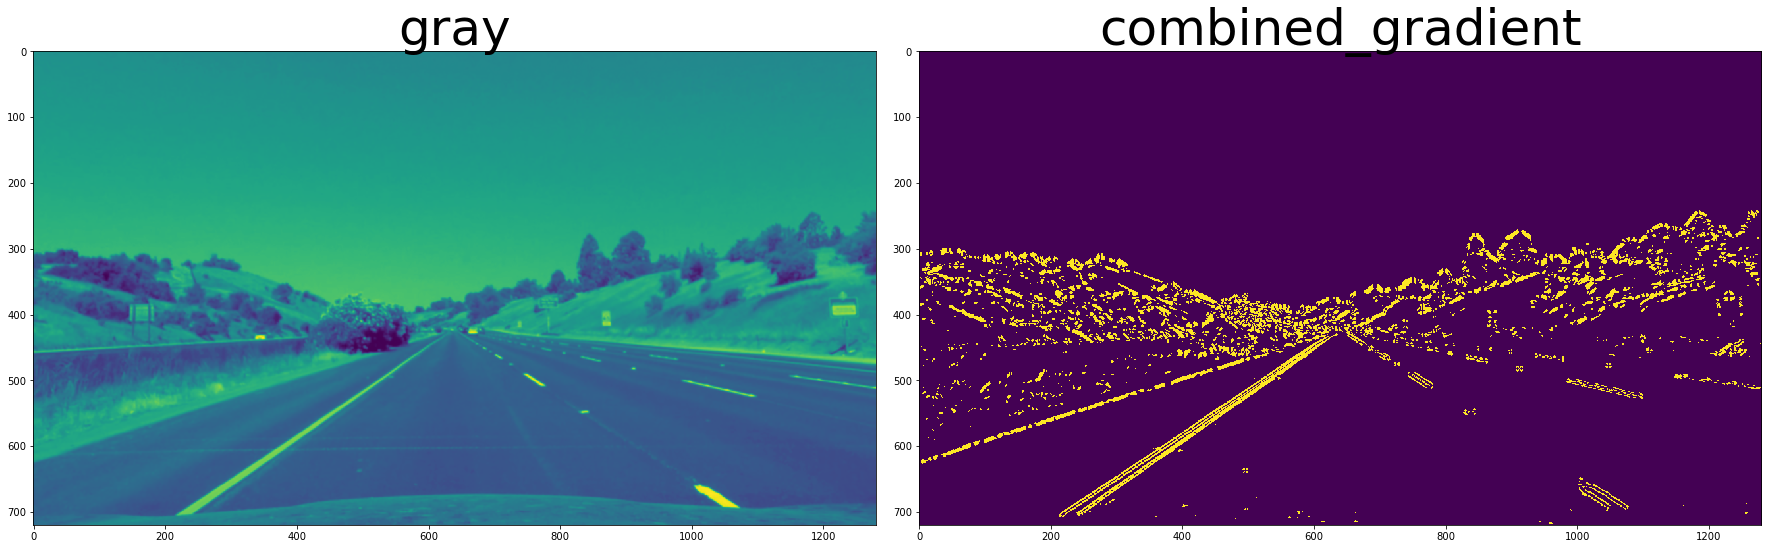

In [17]:
combined_gradient = np.zeros_like(dir_binary)
combined_gradient[((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gray_img,)
ax1.set_title('gray', fontsize=50)
ax2.imshow(combined_gradient)
ax2.set_title('combined_gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




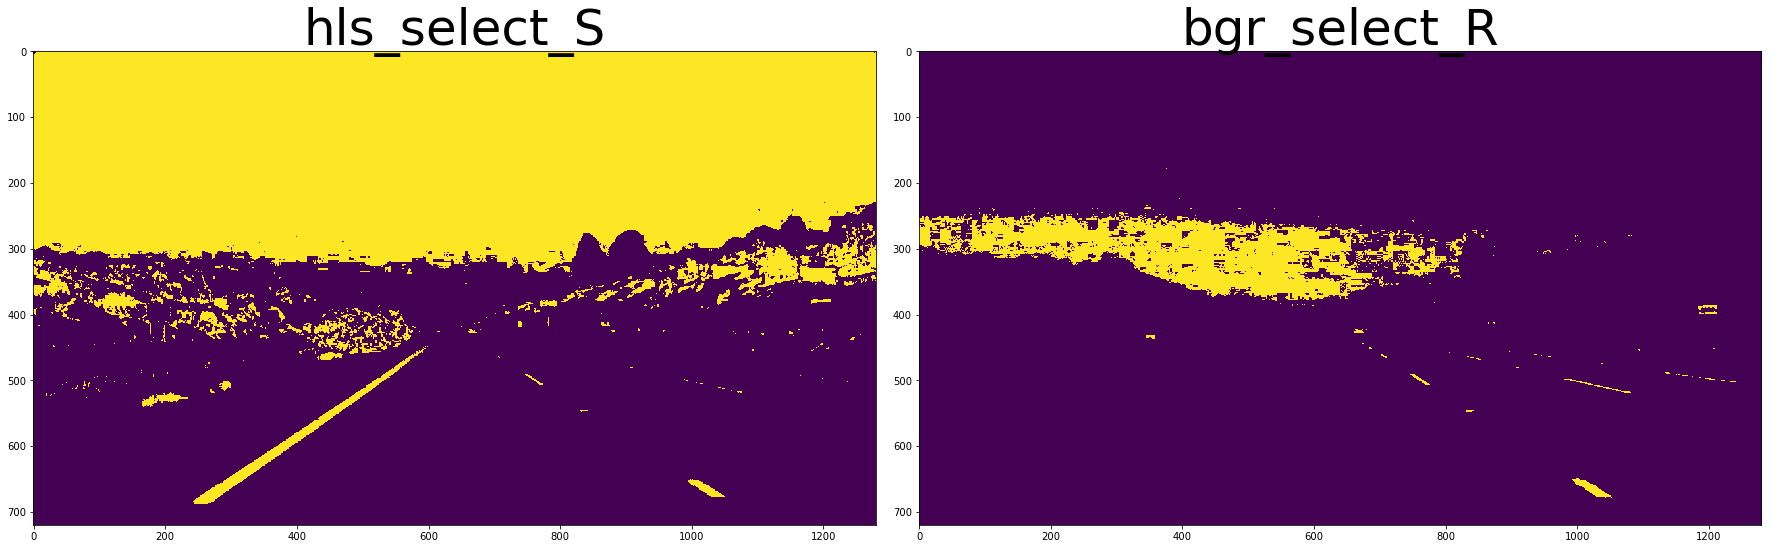

In [18]:
hls_select_S = hls_select(image,channel="S",thresh=(90,255))
bgr_select_R = bgr_select(image,channel="R",thresh=(200,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls_select_S)
ax1.set_title('hls_select_S', fontsize=50)
ax2.imshow(bgr_select_R)
ax2.set_title('bgr_select_R', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

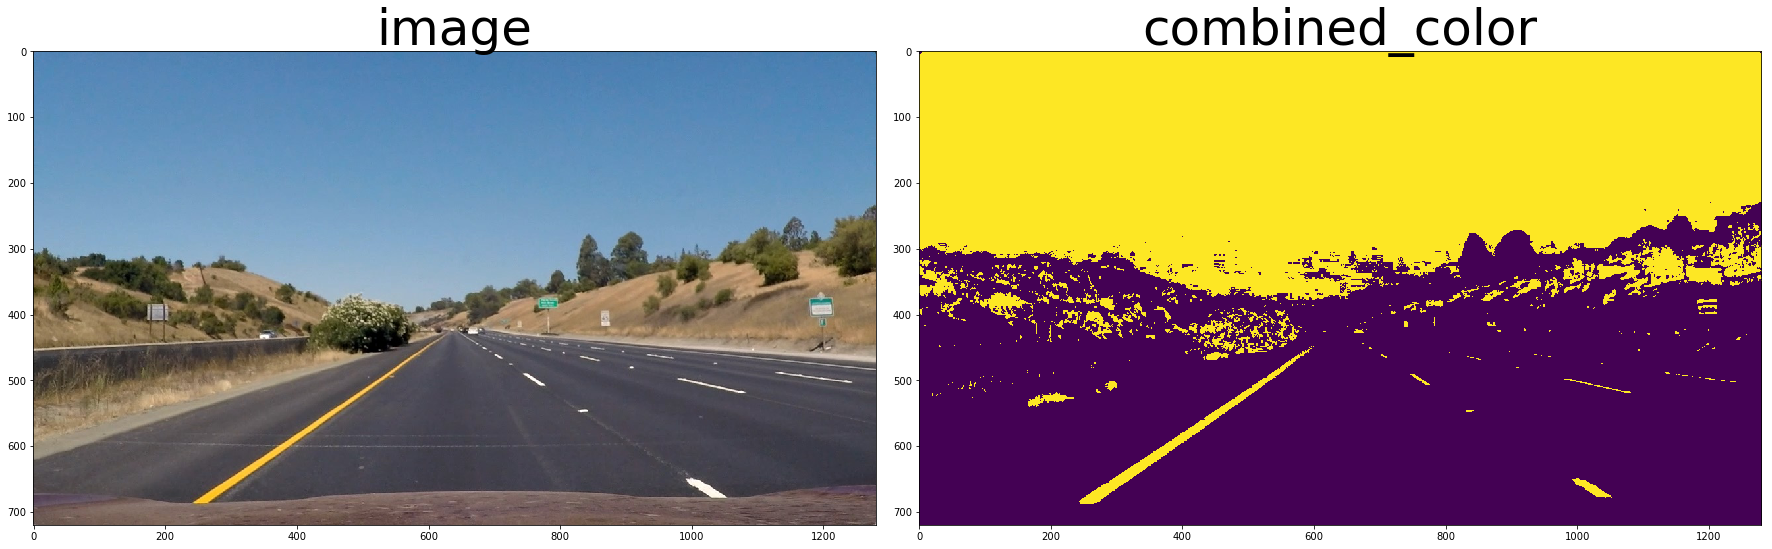

In [19]:
combined_color = np.zeros_like(dir_binary)
combined_color[((hls_select_S == 1) | (bgr_select_R == 1) )] =1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('image', fontsize=50)
ax2.imshow(combined_color)
ax2.set_title('combined_color', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

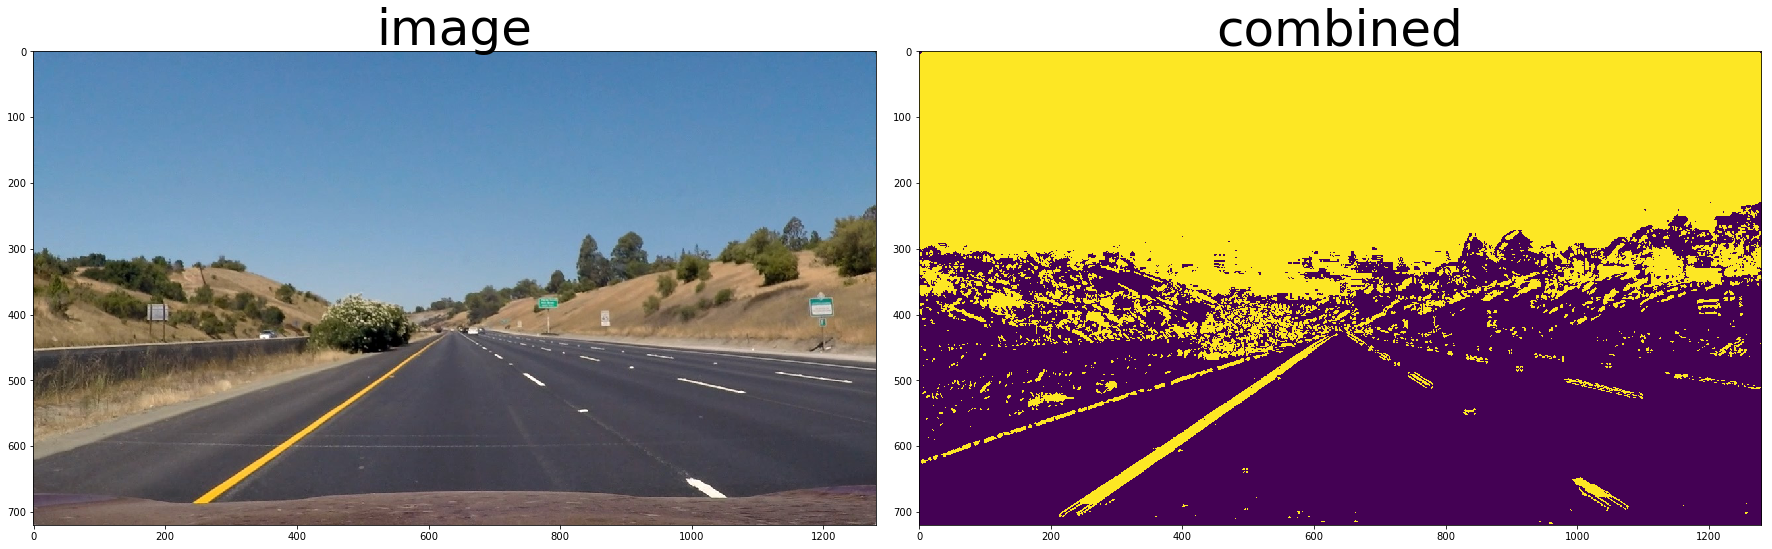

In [20]:
combined = np.zeros_like(dir_binary)
combined[((combined_color == 1) | (combined_gradient == 1) )] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('image', fontsize=50)
ax2.imshow(combined)
ax2.set_title('combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

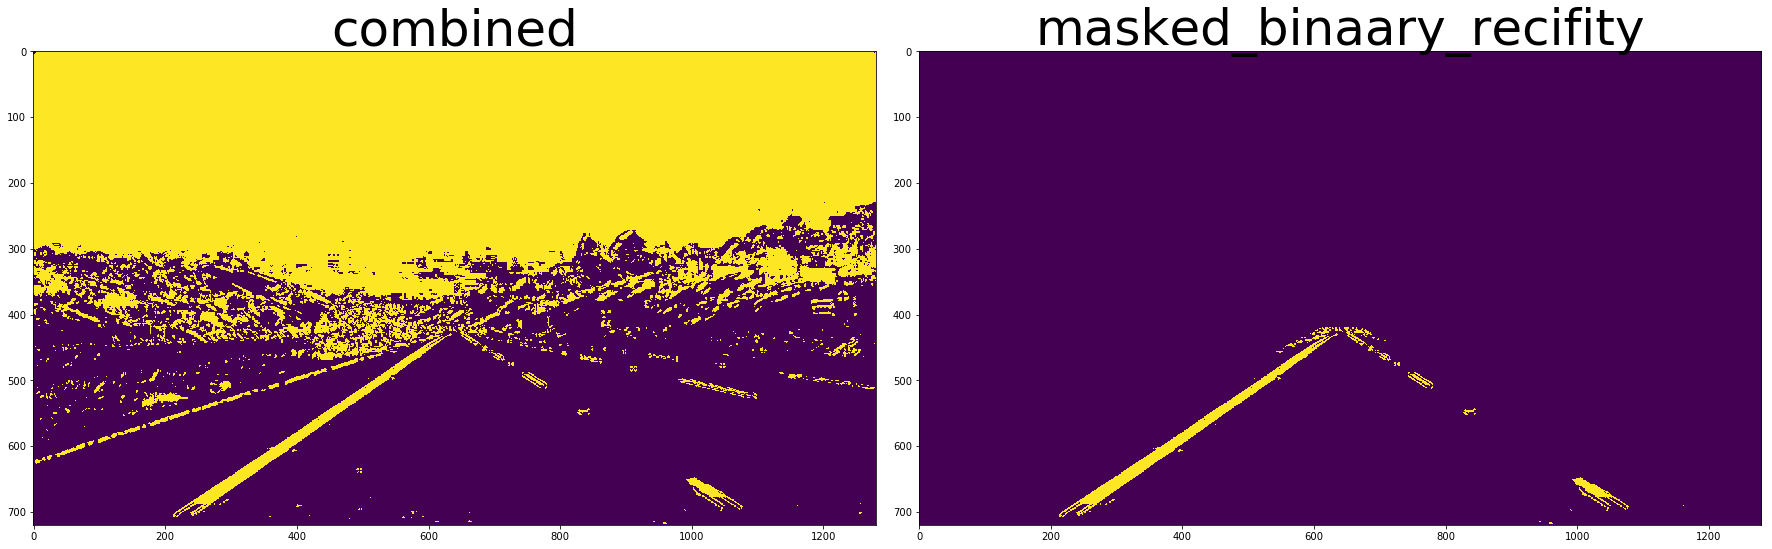

In [21]:
imshape = image.shape
vertices_recifity_mask = np.array([[(30, imshape[0]), 
                          (imshape[1]//2-30, imshape[0]//2+60),
                          (imshape[1]//2+30, imshape[0]//2+60), 
                          (imshape[1], imshape[0]),
                            (imshape[1]//2+300, imshape[0]),
                          (imshape[1]//2, imshape[0] // 2 +90),
                          (imshape[1]//2-300, imshape[0])]], 
                        dtype=np.int32)
masked_binaary_recifity = region_of_interest(combined,vertices_recifity_mask)





f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined)
ax1.set_title('combined', fontsize=50)
ax2.imshow(masked_binaary_recifity)
ax2.set_title('masked_binaary_recifity', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### recitify image

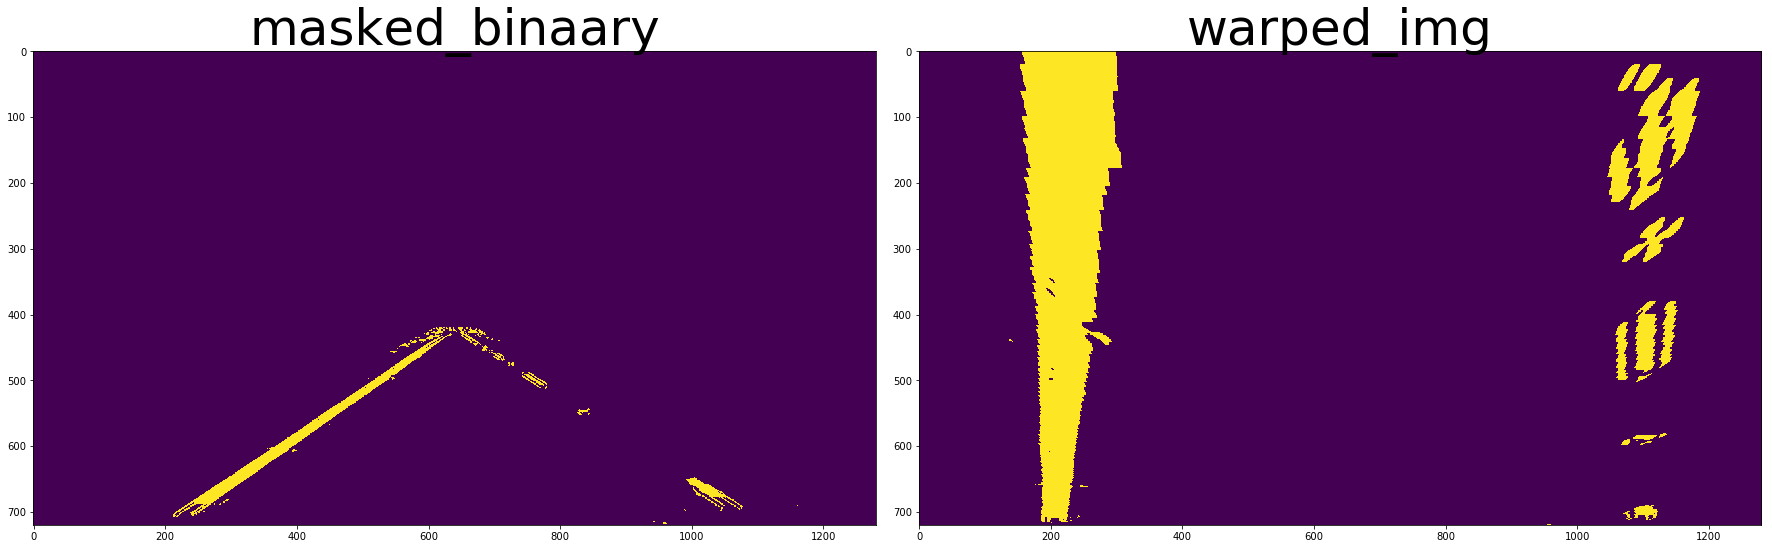

In [22]:

# rho = 5
# theta = np.pi / 180
# threshold = 15
# min_line_length = 60
# max_line_gap = 40





# lined_img,src,dst = get_recitify_element(masked_binaary_recifity,image,rho,theta,threshold,min_line_length,max_line_gap,vertices_recifity_mask)
# print(src,dst)


src = np.float32([[ 205,720],[ 565, 470],[715,470],[1107,720]])
dst = np.float32([[ 205,720],[ 205,235],[1100,235],[1100,720]])


M,M_R = get_M(masked_binaary_recifity,src,dst)
warped_img = recity_unwarp(masked_binaary_recifity,M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(masked_binaary_recifity)
ax1.set_title('masked_binaary', fontsize=50)
ax2.imshow(warped_img)
ax2.set_title('warped_img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




### Detect lane pixels and fit to find the lane boundary.

In [91]:
nwindows = 9 
margin = 100 
minpix = 50 

leftx, lefty, rightx, righty = find_lane_pixels(warped_img,nwindows=nwindows,margin= margin,minpix= minpix)
print(len(leftx))
print(len(rightx))

left_fitx = None
right_fitx = None


left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
print(len(left_fitx))
print(len(right_fitx))



67806
21335
720
720


### Determine the curvature of the lane and vehicle position with respect to center.

In [24]:
ym_per_pix = 30/720
xm_per_pix = 3.7/700


left_curverad, right_curverad,distance = measure_curvature_real(warped_img,ploty,left_fit,right_fit,ym_per_pix,xm_per_pix)
print('left_curverad:',left_curverad)
print('right_curverad:',right_curverad)
print('distance:',distance)

left_curverad: 13625.376443028936
right_curverad: 3801.7162373175634
distance: -0.08396944118775933


In [25]:
# left_curverad, right_curverad,distance = measure_curvature_pixels(warped_img,ploty,left_fit,right_fit)
# print('left_curverad:',left_curverad)
# print('right_curverad:',right_curverad)

### get field

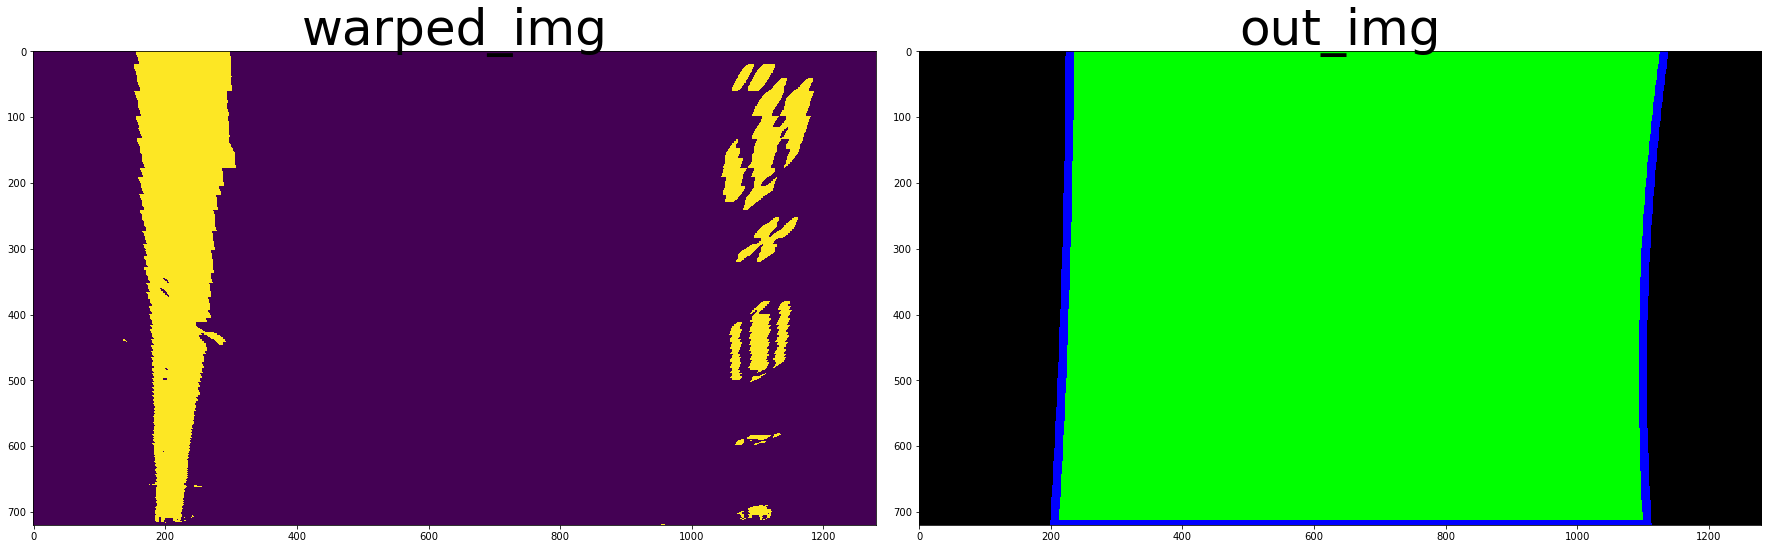

In [26]:
out_img = get_draw(warped_img,left_fitx,right_fitx,ploty)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped_img)
ax1.set_title('warped_img', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('out_img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### back to the original image

(720, 1280, 3)


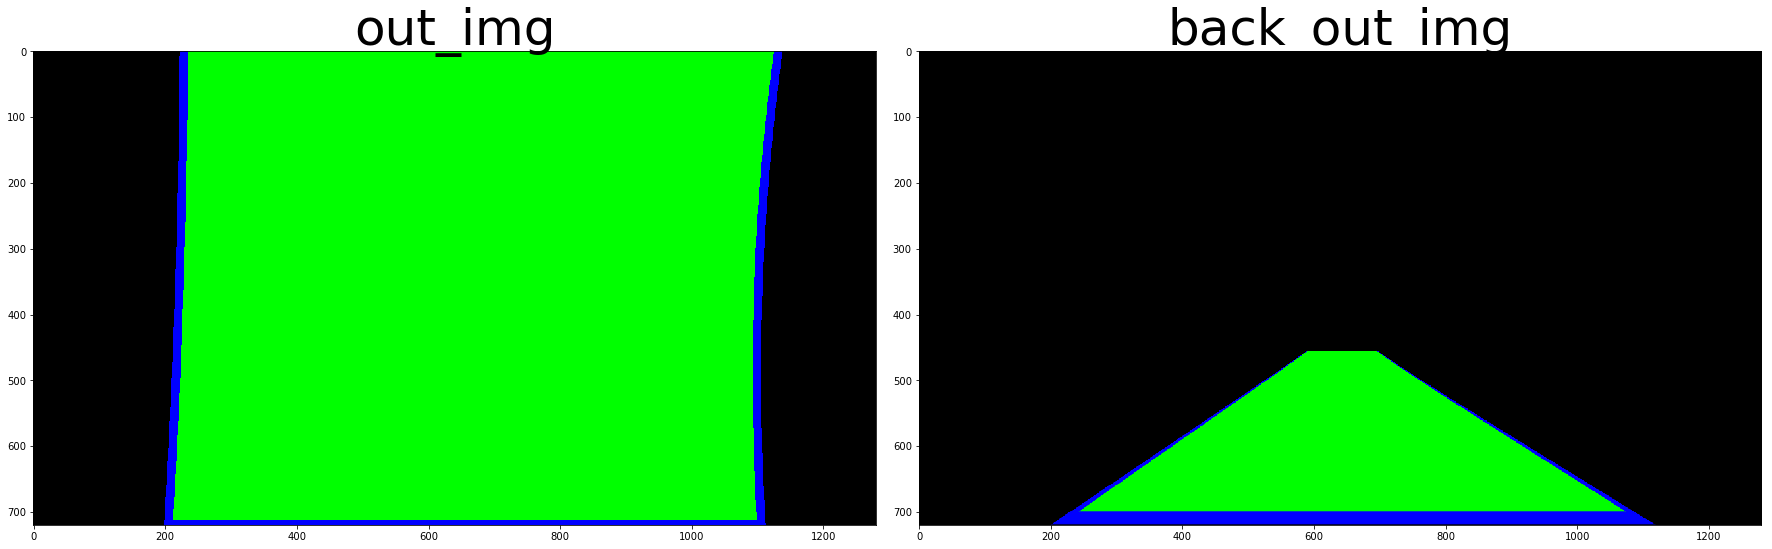

In [27]:
print(out_img.shape)
back_out_img = recity_unwarp_full(out_img,M_R)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('out_img', fontsize=50)
ax2.imshow(back_out_img)
ax2.set_title('back_out_img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### combine images

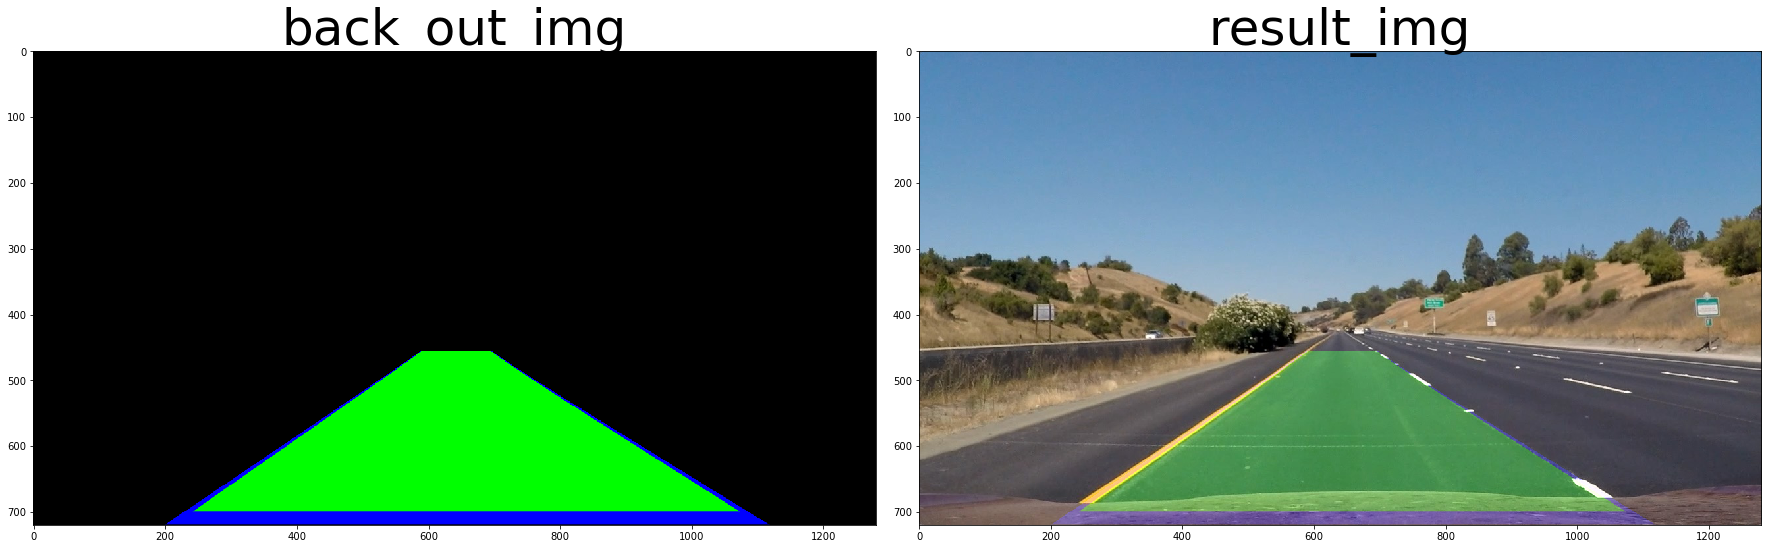

In [28]:
result_img = weighted_img(back_out_img,image,1,0.3,0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(back_out_img)
ax1.set_title('back_out_img', fontsize=50)
ax2.imshow(result_img)
ax2.set_title('result_img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### add text

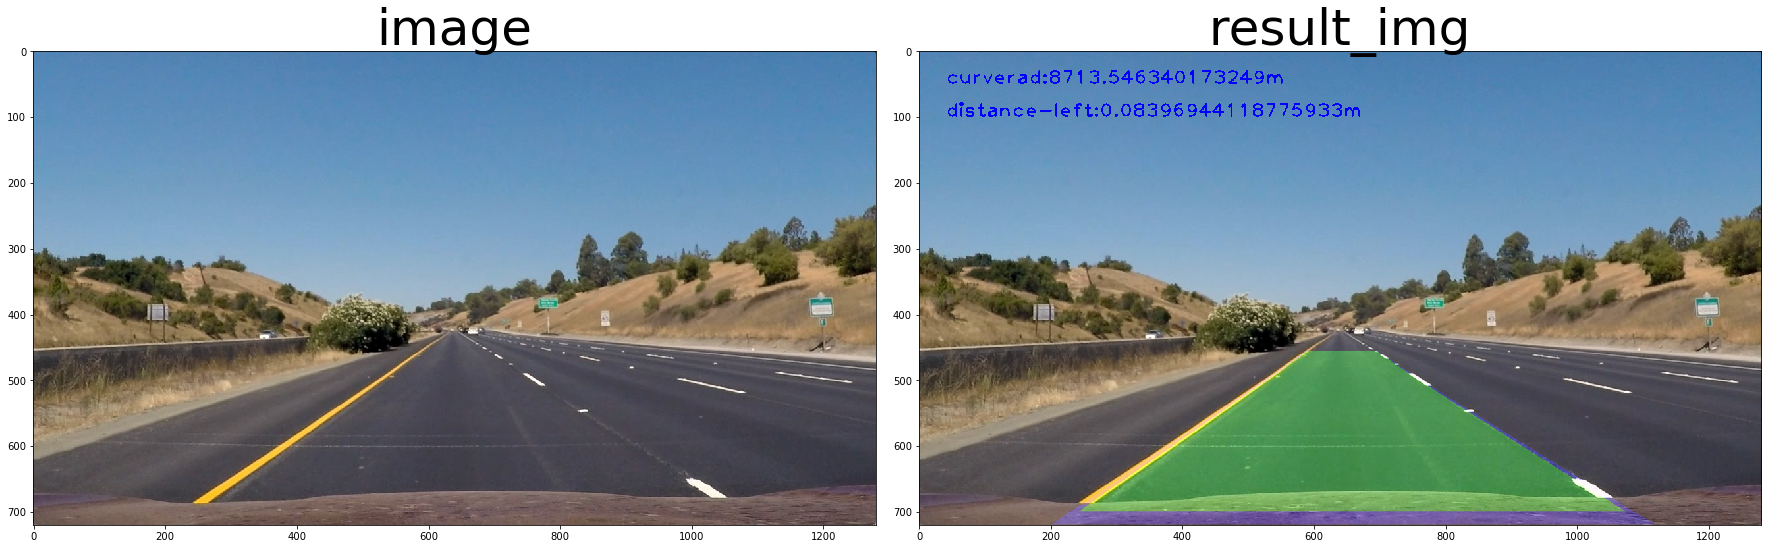

In [29]:
msg = get_info_text(left_curverad,right_curverad,distance)
put_text2img(result_img,msg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('image', fontsize=50)
ax2.imshow(result_img)
ax2.set_title('result_img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test on video 

### import tools

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### perpare

In [39]:
# 相机校准
mages = get_images('./camera_cal/calibration*.jpg')
objpoints,imgpoints = get_points(images)
ret,mtx,dist = get_cal_matrices(img,objpoints,imgpoints)

# 投影矩阵
src = np.float32([[ 205,720],[ 565, 470],[715,470],[1107,720]])
dst = np.float32([[ 205,720],[ 205,235],[1100,235],[1100,720]])


M,M_R = get_M(masked_binaary_recifity,src,dst)

# 超参数
nwindows = 9 
margin = 100 
minpix = 50 

# 像素距离比
ym_per_pix = 30/720
xm_per_pix = 3.7/700

#左右拟合曲线多项式，记录上一帧的
left_fit = None
right_fit = None

### pip line

In [57]:
def pip_line(image):
    
    global left_fit,right_fit
    
#     图像预处理，灰度
    inds_image = cal_undistort(image, mtx, dist)
    gray_img = grayscale(inds_image)
    gray_img = gaussian_smoothing(gray_img,kernel_size = 5)   
    
#     使用索贝尔算子进行边缘检测，分别从x，y方向，x和y的合成方向，角度等方面进行过滤
    abs_sobel_x = abs_sobel_thresh(gray_img,orient="x",sobel_kernel=9,thresh=(20,100))
    abs_sobel_y = abs_sobel_thresh(gray_img,orient="y",sobel_kernel=9,thresh=(20,150))
    
    mag_binary = mag_thresh(gray_img,sobel_kernel=9,thresh=(30,100))
    dir_binary = dir_threshold(gray_img,sobel_kernel=15,thresh=(0.8, 1.3))
    
    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
#     使用hls和rgb色彩空间进行特征值提取
    hls_select_S = hls_select(image,channel="S",thresh=(90,255))
    bgr_select_R = bgr_select(image,channel="R",thresh=(200,255))
#     将各个不同角度提取的车道线合成
    combined_color = np.zeros_like(dir_binary)
    combined_color[((hls_select_S == 1) | (bgr_select_R == 1) )] =1
    
    combined = np.zeros_like(dir_binary)
    combined[((combined_color == 1) | (combined_gradient == 1) )] = 1
    
#     设置感兴趣区域
    vertices_recifity_mask = np.array([[(30, imshape[0]), 
                          (imshape[1]//2-30, imshape[0]//2+60),
                          (imshape[1]//2+30, imshape[0]//2+60), 
                          (imshape[1], imshape[0]),
                            (imshape[1]//2+300, imshape[0]),
                          (imshape[1]//2, imshape[0] // 2 +90),
                          (imshape[1]//2-300, imshape[0])]], 
                        dtype=np.int32)
    masked_binaary_recifity = region_of_interest(combined,vertices_recifity_mask)
    
    #投影鸟瞰图
    warped_img = recity_unwarp(masked_binaary_recifity,M)
    
#     找到左右拟合线
    leftx, lefty, rightx, righty = find_lane_pixels(warped_img,nwindows=nwindows,margin= margin,minpix= minpix)

    left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)

# 如果找到下次就使用上次拟合线周围区域，如果找不到就重新寻找
#     if not ((left_fit != []) and (right_fit != [])):
#         left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
#     else:
#         left_fit,right_fit,left_fitx,right_fitx,ploty = search_around_poly(warped_img,left_fit,right_fit,margin)
        
#     if not ((left_fit != []) and (right_fit != [])):
#         left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
    
    #求出左右曲率和车头偏移距离
    left_curverad, right_curverad,distance = measure_curvature_real(warped_img,ploty,left_fit,right_fit,ym_per_pix,xm_per_pix)
    
#   覆盖层画出车道区域
    out_img = get_draw(warped_img,left_fitx,right_fitx,ploty)
    
#     将覆盖层投影回原图位置
    back_out_img = recity_unwarp_full(out_img,M_R)
    
#     合并覆盖层和原图
    result_img = weighted_img(back_out_img,image,1,0.3,0)
    
#     向图中添加文字
    msg = get_info_text(left_curverad,right_curverad,distance)
    put_text2img(result_img,msg)
    
    return result_img
    
    
    
    

### process video

In [58]:
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pip_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video.mp4
CPU times: user 6min 20s, sys: 45.8 s, total: 7min 6s
Wall time: 9min 46s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### show details about the part not good

In [81]:
# 相机校准
mages = get_images('./camera_cal/calibration*.jpg')
objpoints,imgpoints = get_points(images)
ret,mtx,dist = get_cal_matrices(img,objpoints,imgpoints)

# 投影矩阵
src = np.float32([[ 205,720],[ 565, 470],[715,470],[1107,720]])
dst = np.float32([[ 300,720],[ 300,235],[980,235],[980,720]])


M,M_R = get_M(masked_binaary_recifity,src,dst)

# 超参数
nwindows = 9 
margin = 100 
minpix = 50 

# 像素距离比
ym_per_pix = 30/720
xm_per_pix = 3.5/680

#左右拟合曲线多项式，记录上一帧的
left_fit = None
right_fit = None

In [82]:
def pip_line(image):
    
    global left_fit,right_fit
    
#     图像预处理，灰度
    inds_image = cal_undistort(image, mtx, dist)
    gray_img = grayscale(inds_image)
    gray_img = gaussian_smoothing(gray_img,kernel_size = 5)   
    
#     使用索贝尔算子进行边缘检测，分别从x，y方向，x和y的合成方向，角度等方面进行过滤
    abs_sobel_x = abs_sobel_thresh(gray_img,orient="x",sobel_kernel=9,thresh=(20,100))
    abs_sobel_y = abs_sobel_thresh(gray_img,orient="y",sobel_kernel=9,thresh=(20,150))
    
    mag_binary = mag_thresh(gray_img,sobel_kernel=9,thresh=(30,100))
    dir_binary = dir_threshold(gray_img,sobel_kernel=15,thresh=(0.8, 1.3))
    
    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
#     使用hls和rgb色彩空间进行特征值提取
    hls_select_S = hls_select(image,channel="S",thresh=(90,255))
    bgr_select_R = bgr_select(image,channel="R",thresh=(200,255))
#     将各个不同角度提取的车道线合成
    combined_color = np.zeros_like(dir_binary)
    combined_color[((hls_select_S == 1) | (bgr_select_R == 1) )] =1
    
    combined = np.zeros_like(dir_binary)
    combined[((combined_color == 1) | (combined_gradient == 1) )] = 1
    
#     设置感兴趣区域
    vertices_recifity_mask = np.array([[(30, imshape[0]), 
                          (imshape[1]//2-30, imshape[0]//2+60),
                          (imshape[1]//2+30, imshape[0]//2+60), 
                          (imshape[1], imshape[0]),
                            (imshape[1]//2+300, imshape[0]),
                          (imshape[1]//2, imshape[0] // 2 +90),
                          (imshape[1]//2-300, imshape[0])]], 
                        dtype=np.int32)
    masked_binaary_recifity = region_of_interest(combined,vertices_recifity_mask)
    
    #投影鸟瞰图
    warped_img = recity_unwarp(masked_binaary_recifity,M)
    
#     找到左右拟合线
    leftx, lefty, rightx, righty = find_lane_pixels(warped_img,nwindows=nwindows,margin= margin,minpix= minpix)

    left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)

# 如果找到下次就使用上次拟合线周围区域，如果找不到就重新寻找
#     if not ((left_fit != []) and (right_fit != [])):
#         left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
#     else:
#         left_fit,right_fit,left_fitx,right_fitx,ploty = search_around_poly(warped_img,left_fit,right_fit,margin)
        
#     if not ((left_fit != []) and (right_fit != [])):
#         left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
    
    #求出左右曲率和车头偏移距离
    left_curverad, right_curverad,distance = measure_curvature_real(warped_img,ploty,left_fit,right_fit,ym_per_pix,xm_per_pix)
    
#   覆盖层画出车道区域
    out_img = get_draw(warped_img,left_fitx,right_fitx,ploty)
    
#     将覆盖层投影回原图位置
    back_out_img = recity_unwarp_full(out_img,M_R)
    
#     合并覆盖层和原图
    result_img = weighted_img(back_out_img,image,1,0.3,0)
    
#     向图中添加文字
    msg = get_info_text(left_curverad,right_curverad,distance)
    put_text2img(result_img,msg)
    
    
    
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    return out_img
    
    
    
    

In [83]:
white_output = 'output_images/project_video_outing.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(37,45)
white_clip = clip1.fl_image(pip_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/200 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/project_video_outing.mp4.
Moviepy - Writing video output_images/project_video_outing.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video_outing.mp4
CPU times: user 1min 2s, sys: 8.19 s, total: 1min 11s
Wall time: 1min 23s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### problem

right side is too small,lots of points lost 

### retry

In [88]:
# 相机校准
mages = get_images('./camera_cal/calibration*.jpg')
objpoints,imgpoints = get_points(images)
ret,mtx,dist = get_cal_matrices(img,objpoints,imgpoints)

# 投影矩阵
src = np.float32([[ 205,720],[ 565, 470],[715,470],[1107,720]])
dst = np.float32([[ 300,720],[ 300,235],[980,235],[980,720]])


M,M_R = get_M(masked_binaary_recifity,src,dst)

# 超参数
nwindows = 9 
margin = 100 
minpix = 50 

# 像素距离比
ym_per_pix = 30/720
xm_per_pix = 3.5/680

#左右拟合曲线多项式，记录上一帧的
left_fit = []
right_fit = []

In [89]:
def pip_line(image):
    
    global left_fit,right_fit
    
#     图像预处理，灰度
    inds_image = cal_undistort(image, mtx, dist)
    gray_img = grayscale(inds_image)
    gray_img = gaussian_smoothing(gray_img,kernel_size = 5)   
    
#     使用索贝尔算子进行边缘检测，分别从x，y方向，x和y的合成方向，角度等方面进行过滤
    abs_sobel_x = abs_sobel_thresh(gray_img,orient="x",sobel_kernel=9,thresh=(20,100))
    abs_sobel_y = abs_sobel_thresh(gray_img,orient="y",sobel_kernel=9,thresh=(20,150))
    
    mag_binary = mag_thresh(gray_img,sobel_kernel=9,thresh=(30,100))
    dir_binary = dir_threshold(gray_img,sobel_kernel=15,thresh=(0.8, 1.3))
    
    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
#     使用hls和rgb色彩空间进行特征值提取
    hls_select_S = hls_select(image,channel="S",thresh=(90,255))
    bgr_select_R = bgr_select(image,channel="R",thresh=(200,255))
#     将各个不同角度提取的车道线合成
    combined_color = np.zeros_like(dir_binary)
    combined_color[((hls_select_S == 1) | (bgr_select_R == 1) )] =1
    
    combined = np.zeros_like(dir_binary)
    combined[((combined_color == 1) | (combined_gradient == 1) )] = 1
    
#     设置感兴趣区域
    vertices_recifity_mask = np.array([[(30, imshape[0]), 
                          (imshape[1]//2-30, imshape[0]//2+60),
                          (imshape[1]//2+30, imshape[0]//2+60), 
                          (imshape[1], imshape[0]),
                            (imshape[1]//2+300, imshape[0]),
                          (imshape[1]//2, imshape[0] // 2 +90),
                          (imshape[1]//2-300, imshape[0])]], 
                        dtype=np.int32)
    masked_binaary_recifity = region_of_interest(combined,vertices_recifity_mask)
    
    #投影鸟瞰图
    warped_img = recity_unwarp(masked_binaary_recifity,M)
    
#     找到左右拟合线
    leftx, lefty, rightx, righty = find_lane_pixels(warped_img,nwindows=nwindows,margin= margin,minpix= minpix)

#     left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)

# 如果找到下次就使用上次拟合线周围区域，如果找不到就重新寻找
    if not ((left_fit != []) and (right_fit != [])):
        left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
    else:
        left_fit,right_fit,left_fitx,right_fitx,ploty = search_around_poly(warped_img,left_fit,right_fit,margin)
        
    if not ((left_fit != []) and (right_fit != [])):
        left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
    
    #求出左右曲率和车头偏移距离
    left_curverad, right_curverad,distance = measure_curvature_real(warped_img,ploty,left_fit,right_fit,ym_per_pix,xm_per_pix)
    
#   覆盖层画出车道区域
    out_img = get_draw(warped_img,left_fitx,right_fitx,ploty)
    
#     将覆盖层投影回原图位置
    back_out_img = recity_unwarp_full(out_img,M_R)
    
#     合并覆盖层和原图
    result_img = weighted_img(back_out_img,image,1,0.3,0)
    
#     向图中添加文字
    msg = get_info_text(left_curverad,right_curverad,distance)
    put_text2img(result_img,msg)
    
    
    
#     out_img = np.dstack((warped_img, warped_img, warped_img))*255
    return result_img
    
    
    
    

In [90]:
white_output = 'output_images/project_video_v2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pip_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/project_video_v2.mp4.
Moviepy - Writing video output_images/project_video_v2.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video_v2.mp4
CPU times: user 6min 34s, sys: 33.1 s, total: 7min 7s
Wall time: 9min 48s


In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### more

only use one main lane

In [97]:
# 相机校准
mages = get_images('./camera_cal/calibration*.jpg')
objpoints,imgpoints = get_points(images)
ret,mtx,dist = get_cal_matrices(img,objpoints,imgpoints)

# 投影矩阵
src = np.float32([[ 205,720],[ 565, 470],[715,470],[1107,720]])
dst = np.float32([[ 300,720],[ 300,235],[980,235],[980,720]])


M,M_R = get_M(masked_binaary_recifity,src,dst)

# 超参数
nwindows = 9 
margin = 100 
minpix = 50 


# 左车道/右车道像素值数量的可信范围
acc = 0.6

# 像素距离比
ym_per_pix = 30/720
xm_per_pix = 3.5/680

#左右拟合曲线多项式，记录上一帧的
left_fit = []
right_fit = []



In [105]:
def pip_line(image):
    
    global left_fit,right_fit
    
#     图像预处理，灰度
    inds_image = cal_undistort(image, mtx, dist)
    gray_img = grayscale(inds_image)
    gray_img = gaussian_smoothing(gray_img,kernel_size = 5)   
    
#     使用索贝尔算子进行边缘检测，分别从x，y方向，x和y的合成方向，角度等方面进行过滤
    abs_sobel_x = abs_sobel_thresh(gray_img,orient="x",sobel_kernel=9,thresh=(20,100))
    abs_sobel_y = abs_sobel_thresh(gray_img,orient="y",sobel_kernel=9,thresh=(20,150))
    
    mag_binary = mag_thresh(gray_img,sobel_kernel=9,thresh=(30,100))
    dir_binary = dir_threshold(gray_img,sobel_kernel=15,thresh=(0.8, 1.3))
    
    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
#     使用hls和rgb色彩空间进行特征值提取
    hls_select_S = hls_select(image,channel="S",thresh=(90,255))
    bgr_select_R = bgr_select(image,channel="R",thresh=(200,255))
#     将各个不同角度提取的车道线合成
    combined_color = np.zeros_like(dir_binary)
    combined_color[((hls_select_S == 1) | (bgr_select_R == 1) )] =1
    
    combined = np.zeros_like(dir_binary)
    combined[((combined_color == 1) | (combined_gradient == 1) )] = 1
    
#     设置感兴趣区域
    vertices_recifity_mask = np.array([[(30, imshape[0]), 
                          (imshape[1]//2-30, imshape[0]//2+60),
                          (imshape[1]//2+30, imshape[0]//2+60), 
                          (imshape[1], imshape[0]),
                            (imshape[1]//2+300, imshape[0]),
                          (imshape[1]//2, imshape[0] // 2 +90),
                          (imshape[1]//2-300, imshape[0])]], 
                        dtype=np.int32)
    masked_binaary_recifity = region_of_interest(combined,vertices_recifity_mask)
    
    #投影鸟瞰图
    warped_img = recity_unwarp(masked_binaary_recifity,M)
    
#     找到左右拟合线
    leftx, lefty, rightx, righty = find_lane_pixels(warped_img,nwindows=nwindows,margin= margin,minpix= minpix)

        

    
    # 只使用一条车道线，即点最多最可靠的那条作为参考
    if (len(leftx)/len(rightx))  < acc:
        leftx = rightx - (dst[3][0]-dst[0][0])
        lefty = righty
    elif (len(rightx)/len(leftx)) < acc:
        rightx = leftx + (dst[3][0]-dst[0][0])
        righty = lefty

    
    

    left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)

# 如果找到下次就使用上次拟合线周围区域，如果找不到就重新寻找
#     if not ((left_fit != []) and (right_fit != [])):
#         left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
#     else:
#         left_fit,right_fit,left_fitx,right_fitx,ploty = search_around_poly(warped_img,left_fit,right_fit,margin)
        
#     if not ((left_fit != []) and (right_fit != [])):
#         left_fit,right_fit,left_fitx,right_fitx,ploty = fit_poly(gray_img.shape,leftx,lefty,rightx,righty)
    
    #求出左右曲率和车头偏移距离
    left_curverad, right_curverad,distance = measure_curvature_real(warped_img,ploty,left_fit,right_fit,ym_per_pix,xm_per_pix)
    
#   覆盖层画出车道区域
    out_img = get_draw(warped_img,left_fitx,right_fitx,ploty)
    
#     将覆盖层投影回原图位置
    back_out_img = recity_unwarp_full(out_img,M_R)
    
#     合并覆盖层和原图
    result_img = weighted_img(back_out_img,image,1,0.3,0)
    
#     向图中添加文字
    msg = get_info_text(left_curverad,right_curverad,distance)
    put_text2img(result_img,msg)
    
    
    
#     out_img = np.dstack((warped_img, warped_img, warped_img))*255
    return result_img
    
    
    
    

In [106]:
white_output = 'output_images/project_video_v3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pip_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/project_video_v3.mp4.
Moviepy - Writing video output_images/project_video_v3.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video_v3.mp4
CPU times: user 6min 18s, sys: 2.26 s, total: 6min 21s
Wall time: 8min 59s


In [107]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))